In [92]:
import os
import sys
import argparse
import scipy.io
import numpy as np
import librosa
import matplotlib.pyplot as plt

resdir  = '/Users/schwarz/Documents/projects/ABC DJ/src-git/unmixing/results-unmixdb-full/'
mixbase = 'set275mix3-resample-compressor-22'

resname = resdir + mixbase + '.mat'
rmsname = resdir + mixbase + '-rms.mat'

res = scipy.io.loadmat(resname, simplify_cells=True)
rms = scipy.io.loadmat(rmsname, simplify_cells=True)
#print(res)

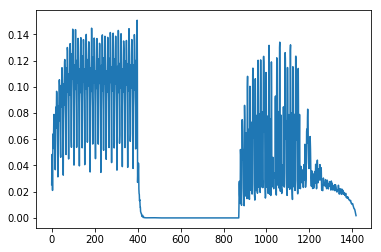

In [93]:
# check loudness of whole mix
plt.plot(rms['rms'])

312 104.0 3
  0 start 103.5 duration   1.2  /Volumes/Data/ABC DJ data/unmixdb-v1/mixotic-set275-excerpts/mixes/set275mix3-none-bass-00.mp3
  3 start   0.0 duration   2.2  /Volumes/Data/ABC DJ data/unmixdb-v1/mixotic-set275-excerpts/mixes/set275mix3-none-bass-03.mp3
  3 start 106.6 duration   2.6  /Volumes/Data/ABC DJ data/unmixdb-v1/mixotic-set275-excerpts/mixes/set275mix3-none-bass-03.mp3
  5 start 104.6 duration   2.9  /Volumes/Data/ABC DJ data/unmixdb-v1/mixotic-set275-excerpts/mixes/set275mix3-none-bass-05.mp3
  8 start 100.6 duration   3.6  /Volumes/Data/ABC DJ data/unmixdb-v1/mixotic-set275-excerpts/mixes/set275mix3-none-bass-08.mp3
 10 start 103.1 duration   1.1  /Volumes/Data/ABC DJ data/unmixdb-v1/mixotic-set275-excerpts/mixes/set275mix3-none-bass-10.mp3
 11 start 103.1 duration   1.4  /Volumes/Data/ABC DJ data/unmixdb-v1/mixotic-set275-excerpts/mixes/set275mix3-none-bass-11.mp3
 14 start  97.9 duration   8.0  /Volumes/Data/ABC DJ data/unmixdb-v1/mixotic-set275-excerpts/mixes/

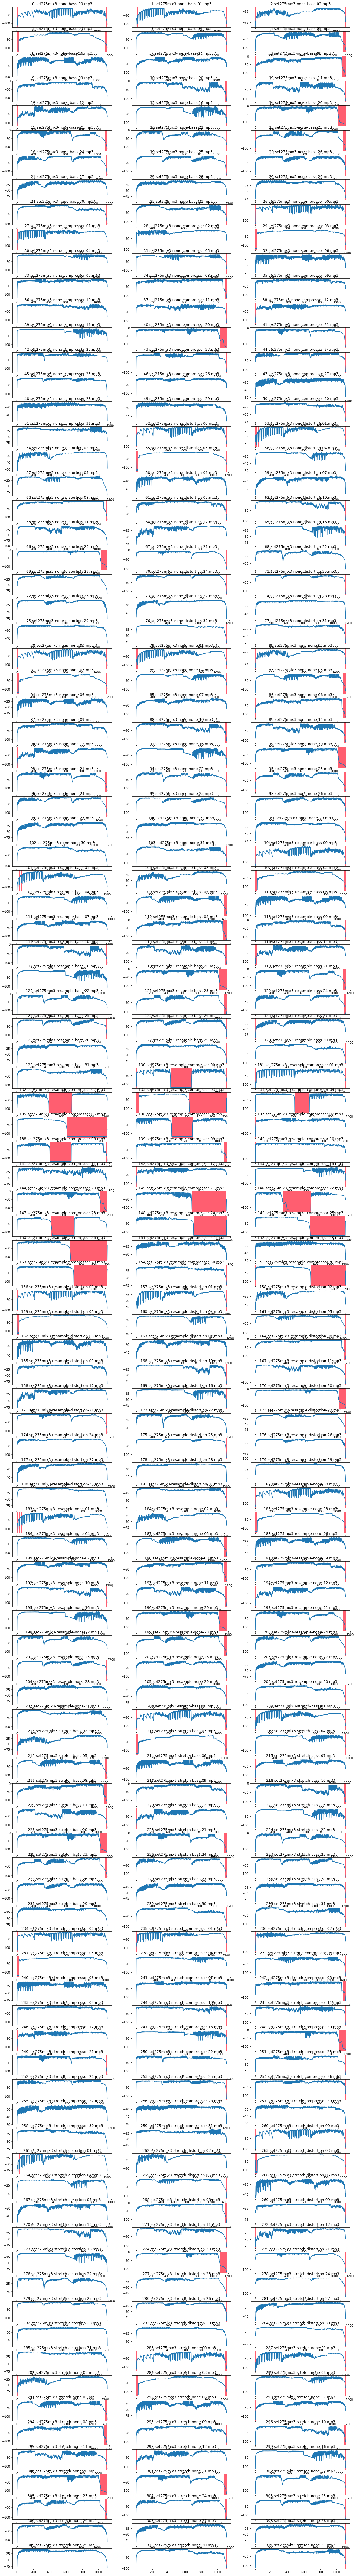

In [13]:
# check for long silent parts in mixes
import os
import glob
import soundfile
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def find_runs (cond):
    _, i, c = np.unique(np.r_[[0], cond[:-1] != cond[1:]].cumsum(),
                    return_index = 1,                   
                    return_counts = 1)

    for index, count in zip(i, c):
        if cond[index]:
            yield index, count
        
# refsongdir = '/Users/schwarz/Documents/projects/ABC DJ/data/unmixdb/excerpts/set123/refsongs/'
# refsongdir = '/Volumes/Data/ABC DJ data/unmixdb-v1/mixotic-set275-excerpts/refsongs/'
refsongdir = '/Volumes/Data/ABC DJ data/unmixdb-v1/mixotic-set275-excerpts/mixes/'

mp3list = glob.glob(refsongdir + '*.mp3')
winsize = 4096
hopsize = 4096

n = 3
m = np.ceil(len(mp3list) / n)
print(len(mp3list), m, n)
plt.figure(figsize=(20, m * 1.5))
plt.tight_layout()

# output dataframes
files  = pd.DataFrame([], columns = ['mixname', 'sr', 'samples'])
chunks = pd.DataFrame([], columns = ['mixname', 'start', 'length', 'duration'])

for i, mp3name in enumerate(mp3list):
    y, sr = soundfile.read(mp3name)

    # to mono
    y = np.sum(y, axis=1)
    #print(y.shape)

    # Extract RMS, convert to dB (clip at -120dB)
    rms = np.squeeze(20 * np.log10(librosa.feature.rms(y=y, frame_length=winsize, hop_length=hopsize) + 1e-6))
    #print(rms.shape, min(rms), max(rms))
    plt.subplot(m, n, i + 1)
    plt.plot(np.squeeze(rms))
    plt.title(f'{i} ' + os.path.basename(mp3name))
    
    # result matrix columns: 
    # silence framestartsamp, silence framenumsamps, silence in seconds
    res = [ ]
    
    # find chunks <-70dB
    for start, count in find_runs(rms < -70):
        sstart = start * hopsize
        sdur   = (count - 1) * hopsize + winsize
        tstart = sstart / sr
        tdur   = sdur / sr
        
        # append to result matrix 
        res.append([ mp3name, sstart, sdur, tdur ])
        
        if tdur > 1:
            print(f'{i:3} start {tstart: >5.1f} duration {tdur: >5.1f}  {mp3name}')
        plt.axvspan(start, start + count, facecolor=(1, 0.1, 0.2, 0.7))
        
    # convert to dataframes: 
    # file with mixname, sr, duration in samples 
    newf = pd.DataFrame([[mp3name, sr, len(y)]], columns = ['mixname', 'sr', 'samples'])
    newchunks = pd.DataFrame(res, columns = ['mixname', 'start', 'length', 'duration'])

    # append and save
    files  = pd.concat([files,  newf],      ignore_index=True)
    chunks = pd.concat([chunks, newchunks], ignore_index=True)
    
    files.to_csv(path_or_buf='files.csv', sep='\t')
    chunks.to_csv(path_or_buf='chunks.csv', sep='\t')
    files.to_json(path_or_buf='files.json', orient='records')
    chunks.to_json(path_or_buf='chunks.json', orient='records')   

In [89]:
# try to find run of silent frames
# 
cond = rms < -70
ind = np.argwhere(cond)
dind = ind[1:] - ind[:-1]
arr = np.squeeze(dind)
#print(cond, ind, dind)
#print(arr)

# not good: finds consecutive indices
_, i, c = np.unique(np.r_[[0], ~np.isclose(arr[:-1], arr[1:])].cumsum(), 
                    return_index = 1, 
                    return_counts = 1)
for index, count in zip(i, c):
    if count > 1:
        pass#print('start', index, 'len', count, 'duration', ((count - 1) * hopsize + winsize)/ sr)
        
# good        
cond = np.array([True,True,True,False,False,True,True,False,True])
print(cond)

_, i, c = np.unique(np.r_[[0], cond[:-1] != cond[1:]].cumsum(),
                    return_index = 1,                   
                    return_counts = 1)
for index, count in zip(i, c):
    if cond[index]:
        print(cond[index], 'start', index, 'len', count)
        

[ True  True  True False False  True  True False  True]
True start 0 len 3
True start 5 len 2
True start 8 len 1


(1940480,) /Users/schwarz/Documents/projects/ABC DJ/data/unmixdb/excerpts/set123/refsongs/04_Hiroshi_Oki_-_Unagui_-_Antiritmo011.excerpt40.mp3


Text(0.5, 1.0, '/Users/schwarz/Documents/projects/ABC DJ/data/unmixdb/excerpts/set123/refsongs/04_Hiroshi_Oki_-_Unagui_-_Antiritmo011.excerpt40.mp3')

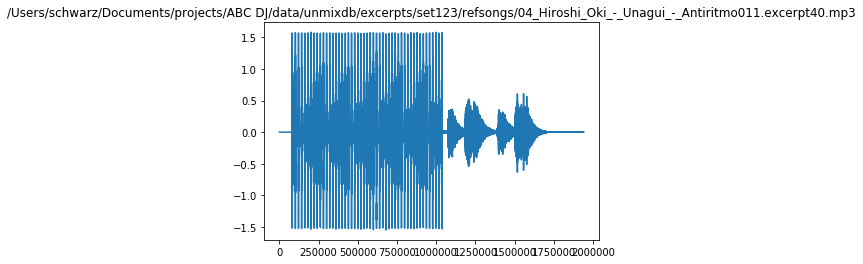

In [12]:
print(y.shape, mp3name)
plt.plot(y)
plt.title(mp3name)

164721757 22050


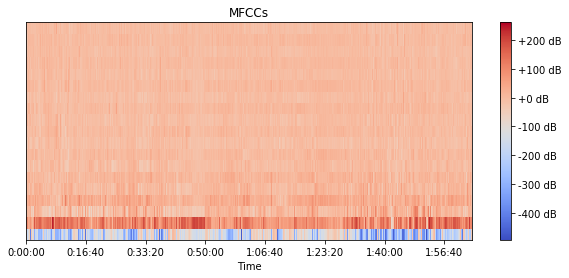

In [7]:
import librosa.display
import matplotlib.pyplot as plt

# Load audio file
audio_file = refsongdir + '01_Sascha_Muller_-_The_Book_Writer_-_Antiritmo002.excerpt40.mp3'
#audio_file = refsongdir + '02_Katsuyuki_Taguchi_-_Indigoblue_-_Antiritmo028.excerpt40.mp3'
audio_file = '/Users/schwarz/Music/radio/RL-2024-05-02-22-00.mp3'
y, sr = librosa.load(audio_file)
print(len(y), sr)

# Extract MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr)

# Display MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCCs')
plt.show()

In [31]:
# join 2 dataframes to find *good* mixes without too long silence
import re
import numpy as np
import pandas as pd
import tabloo
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

v11dir = 'unmixdb-v1.1/'
unmixdbdir = '../unmixdb/'
silencethresh = 4.0

files  = pd.read_csv(v11dir + 'files.csv',  sep = '\t', index_col = 0)
chunks = pd.read_csv(v11dir + 'chunks.csv', sep = '\t', index_col = 0)
badchunks = chunks.loc[chunks['duration'] > silencethresh]

# left join to get all mixes on left, all silent chunks over threshold on right, keep only mixes without anything on right
#goodfiles = files.join(chunks, on = 'mixname') # nope, join always uses left index
filterfiles = pd.merge(files, badchunks, how = 'left', on = 'mixname', indicator = 'check', left_index=False)

# use indicator column from merge to select only columns for which no bad chunks existed (NULL in right half of join shows as NaN, is obfuscated by pandas)
goodfiles = filterfiles.loc[filterfiles['check'] == 'left_only', 'mixname']

# clean up file prefix
pre = re.compile(unmixdbdir)
basefiles = goodfiles.apply(lambda x: pre.sub('', x))

# write list of good mixes to text file
basefiles.to_csv(v11dir + f'unmixdb-v1.1-goodmixes-silence-less-than-{silencethresh:g}s.csv', columns = ['mixname'], header = False, index = False)
print(f'num total mixes: {len(files)}, num good mixes with less than {silencethresh}s of silence: {len(basefiles)}, num dropped mixes: {len(files) - len(basefiles)}')

print(filterfiles)
print(goodfiles)
tabloo.show(badchunks)
#tabloo.show(filterfiles)
#tabloo.show(goodfiles)

num total mixes: 2460, num good mixes with less than 4.0s of silence: 2263, num dropped mixes: 197
                                                                      mixname     sr  samples  start  length  duration      check
0        ../unmixdb/mixotic-set044-excerpts/mixes/set044mix3-none-bass-00.mp3  44100  4721664    NaN     NaN       NaN  left_only
1        ../unmixdb/mixotic-set044-excerpts/mixes/set044mix3-none-bass-01.mp3  44100  4774912    NaN     NaN       NaN  left_only
2        ../unmixdb/mixotic-set044-excerpts/mixes/set044mix3-none-bass-02.mp3  44100  4719616    NaN     NaN       NaN  left_only
3        ../unmixdb/mixotic-set044-excerpts/mixes/set044mix3-none-bass-03.mp3  44100  4713472    NaN     NaN       NaN  left_only
4        ../unmixdb/mixotic-set044-excerpts/mixes/set044mix3-none-bass-04.mp3  44100  4652032    NaN     NaN       NaN  left_only
...                                                                       ...    ...      ...    ...     ...       ...   

num total mixes: 2460, num good mixes with less than 4.0s of silence: 2263, num dropped mixes: 197


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdab1ea7d68>]],
      dtype=object)

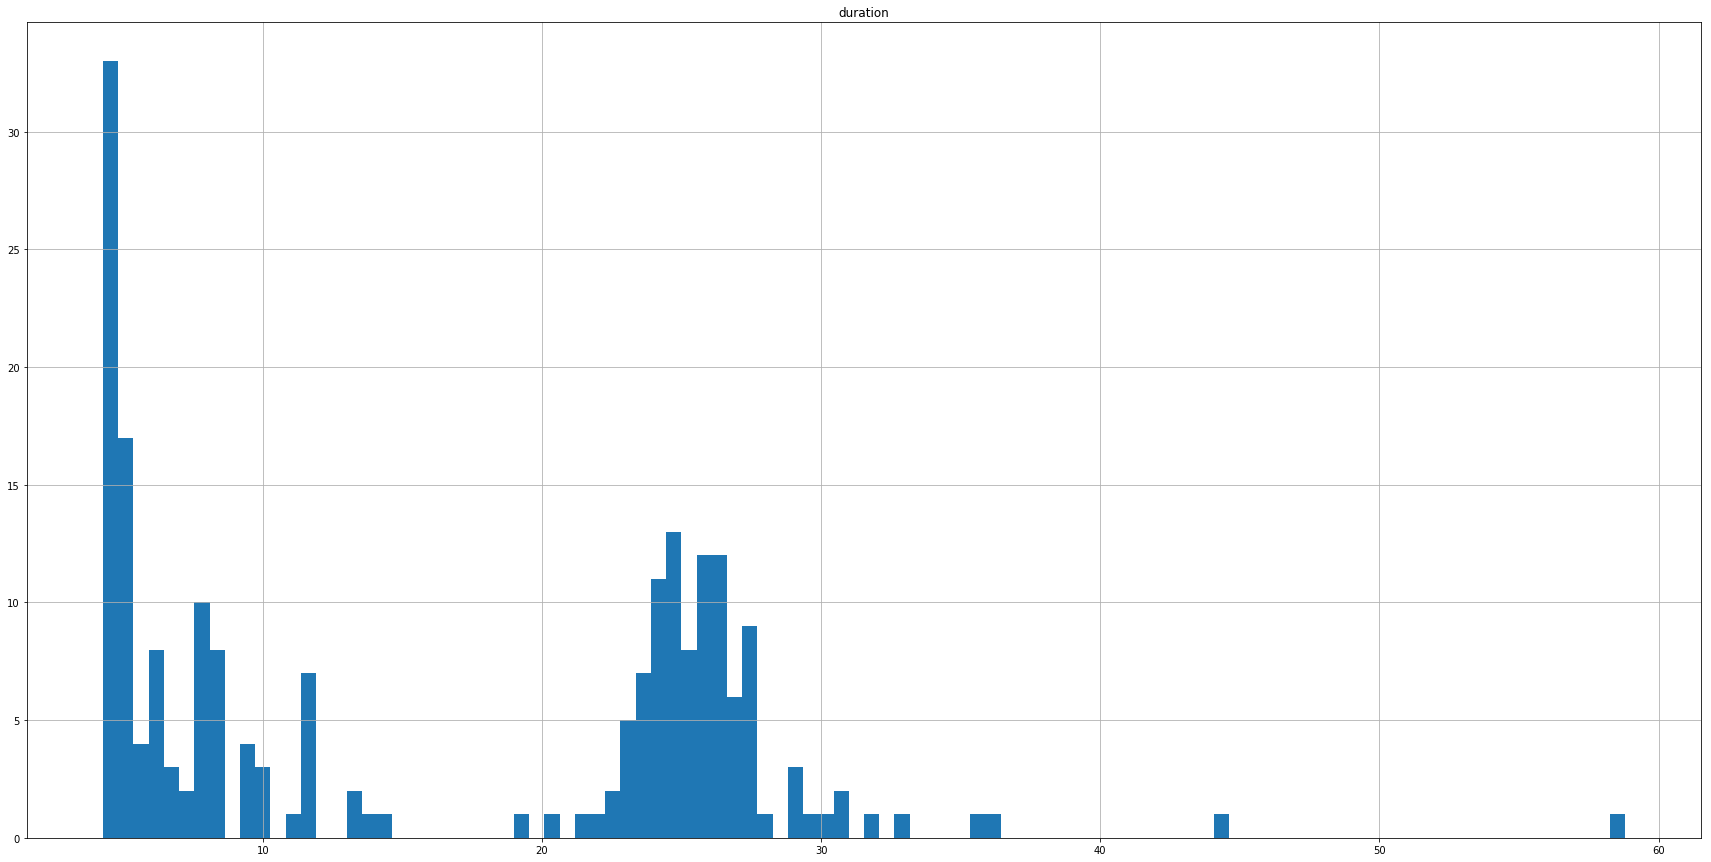

In [27]:
badchunks.hist(column = 'duration', bins = 100, figsize = (30, 15))

# Clean unmixdb from Mixes containing Tracks with silence
- more stringent than just removing mixes with silence > 4s
- silent parts in tracks are not realistic in a DJ mix and throw off the NMF unmixing algorithm
- will write 3 tables:
  1. all track names
  2. all silent chunks in tracks
  3. all mixes to track mappings
- query will filter mixes containing any track with long silence
- re-filter against mixes with long silences (from sox failures)

37 13.0 3


9it [00:00, 18.70it/s]

  5 start   0.0 duration   2.8  excerpts/set123/refsongs/03_Peter_Gual_-_Crits_d_uralita_-_Antiritmo014.excerpt40.mp3
  5 start  39.7 duration   4.0  excerpts/set123/refsongs/03_Peter_Gual_-_Crits_d_uralita_-_Antiritmo014.excerpt40.mp3
  8 start   0.0 duration   1.9  excerpts/set123/refsongs/04_Pepe_Arcade_-_X2_Hiroshi_Oki_Remix_-_Antiritmo017.excerpt40.mp3


13it [00:00, 19.25it/s]

  9 start   0.0 duration   1.9  excerpts/set123/refsongs/03_Hiroshi_Oki_-_Vibrations_-_Antiritmo011.excerpt40.mp3
 13 start  42.4 duration   1.6  excerpts/set123/refsongs/01_Choenyi_-_PA_To_M_-_Antiritmo024.excerpt40.mp3


20it [00:01, 18.82it/s]

 18 start   0.0 duration   1.9  excerpts/set123/refsongs/02_Hiroshi_Oki_-_Sig_Sauer_p226_-_Antiritmo011.excerpt40.mp3
 18 start  42.3 duration   3.0  excerpts/set123/refsongs/02_Hiroshi_Oki_-_Sig_Sauer_p226_-_Antiritmo011.excerpt40.mp3
 19 start   0.0 duration   1.9  excerpts/set123/refsongs/01_Hiroshi_Oki_-_Polar_Circle_-_Antiritmo011.excerpt40.mp3
 19 start  42.4 duration   2.9  excerpts/set123/refsongs/01_Hiroshi_Oki_-_Polar_Circle_-_Antiritmo011.excerpt40.mp3


26it [00:01, 18.20it/s]

 22 start  45.2 duration   3.2  excerpts/set123/refsongs/05_Roger_M_-_Leaving_the_big_D_Outro_-_Antiritmo023.excerpt40.mp3
 25 start   0.0 duration   1.0  excerpts/set123/refsongs/02_Peter_Gual_-_Discutir_-_Antiritmo014.excerpt40.mp3
 25 start  59.9 duration   1.2  excerpts/set123/refsongs/02_Peter_Gual_-_Discutir_-_Antiritmo014.excerpt40.mp3


30it [00:01, 17.18it/s]

 26 start   0.0 duration   1.2  excerpts/set123/refsongs/01_Peter_Gual_-_Cami_De_Insectes_-_Antiritmo014.excerpt40.mp3
 27 start   0.0 duration   1.4  excerpts/set123/refsongs/01_Roger_M_-_Entering_the_big_D_Intro_-_Antiritmo023.excerpt40.mp3


34it [00:01, 18.12it/s]

 31 start   0.0 duration   2.1  excerpts/set123/refsongs/04_Peter_Gual_-_Altres_Llums_-_Antiritmo014.excerpt40.mp3
 31 start  45.6 duration   1.8  excerpts/set123/refsongs/04_Peter_Gual_-_Altres_Llums_-_Antiritmo014.excerpt40.mp3
 32 start   0.0 duration   2.0  excerpts/set123/refsongs/01_Pepe_Arcade_-_X2_Original_Mix_-_Antiritmo017.excerpt40.mp3
 32 start  42.4 duration   1.7  excerpts/set123/refsongs/01_Pepe_Arcade_-_X2_Original_Mix_-_Antiritmo017.excerpt40.mp3
 34 start  42.4 duration   2.8  excerpts/set123/refsongs/04_Hermetico_-_Vision_Nocturna_-_Antiritmo24.excerpt40.mp3


37it [00:02, 18.21it/s]


 36 start   0.0 duration   1.9  excerpts/set123/refsongs/04_Hiroshi_Oki_-_Unagui_-_Antiritmo011.excerpt40.mp3
 36 start  39.0 duration   5.0  excerpts/set123/refsongs/04_Hiroshi_Oki_-_Unagui_-_Antiritmo011.excerpt40.mp3


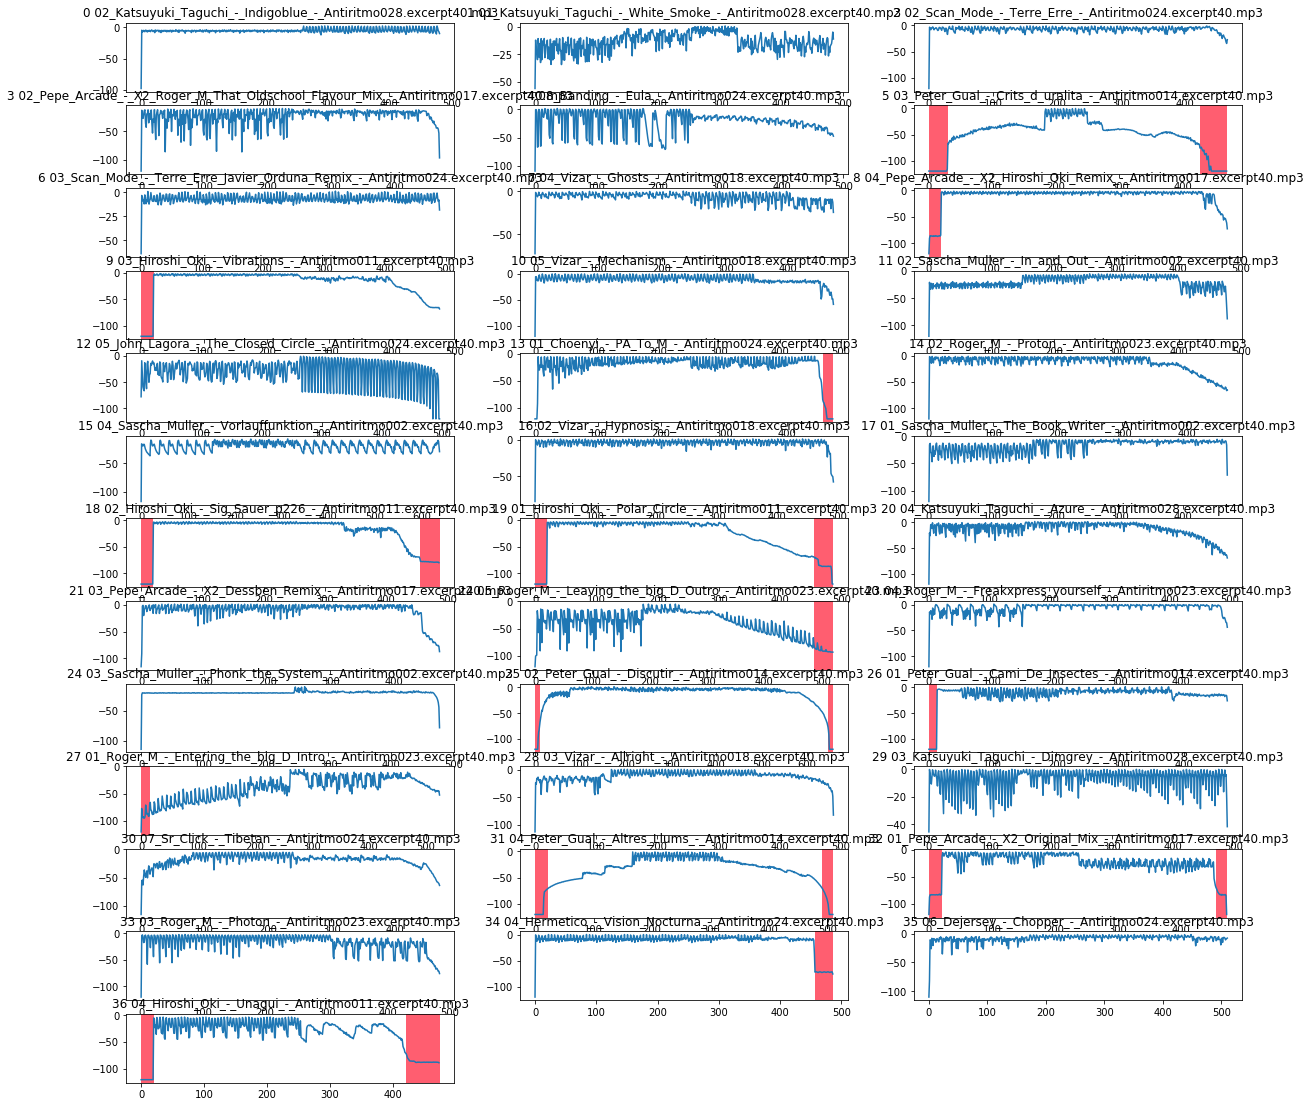

In [3]:
# check for long silent parts in TRACKS
import glob
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
import check_silence as chks
reload(chks)

unmixdbdir = '/Users/schwarz/Documents/projects/ABC DJ/data/unmixdb/'
refsongdir = unmixdbdir + 'excerpts/set123/refsongs/'
# unmixdbdir = '../../unmixdb/'
# refsongdir = unmixdbdir + 'mixotic-set275-excerpts/refsongs/'

mp3list = glob.glob(refsongdir + '*.mp3')
winsize = 4096
hopsize = 4096

n = 3
m = np.ceil(len(mp3list) / n)
print(len(mp3list), m, n)
plt.figure(figsize=(20, m * 1.5))
plt.tight_layout()

rfi, res = chks.find_silence(mp3list, -70, prefix = unmixdbdir, plot = (m, n))
        
# convert to dataframes: 
files  = pd.DataFrame(rfi, columns = ['trackname', 'sr', 'samples'])
chunks = pd.DataFrame(res, columns = ['trackname', 'start', 'length', 'duration'])

# save
files.to_csv  (path_or_buf='alltracks.csv', sep='\t')
chunks.to_csv (path_or_buf='alltracksilencechunks.csv', sep='\t')
files.to_json (path_or_buf='alltracks.json', orient='records')
chunks.to_json(path_or_buf='alltracksilencechunks.json', orient='records')   

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce39cca908>]],
      dtype=object)

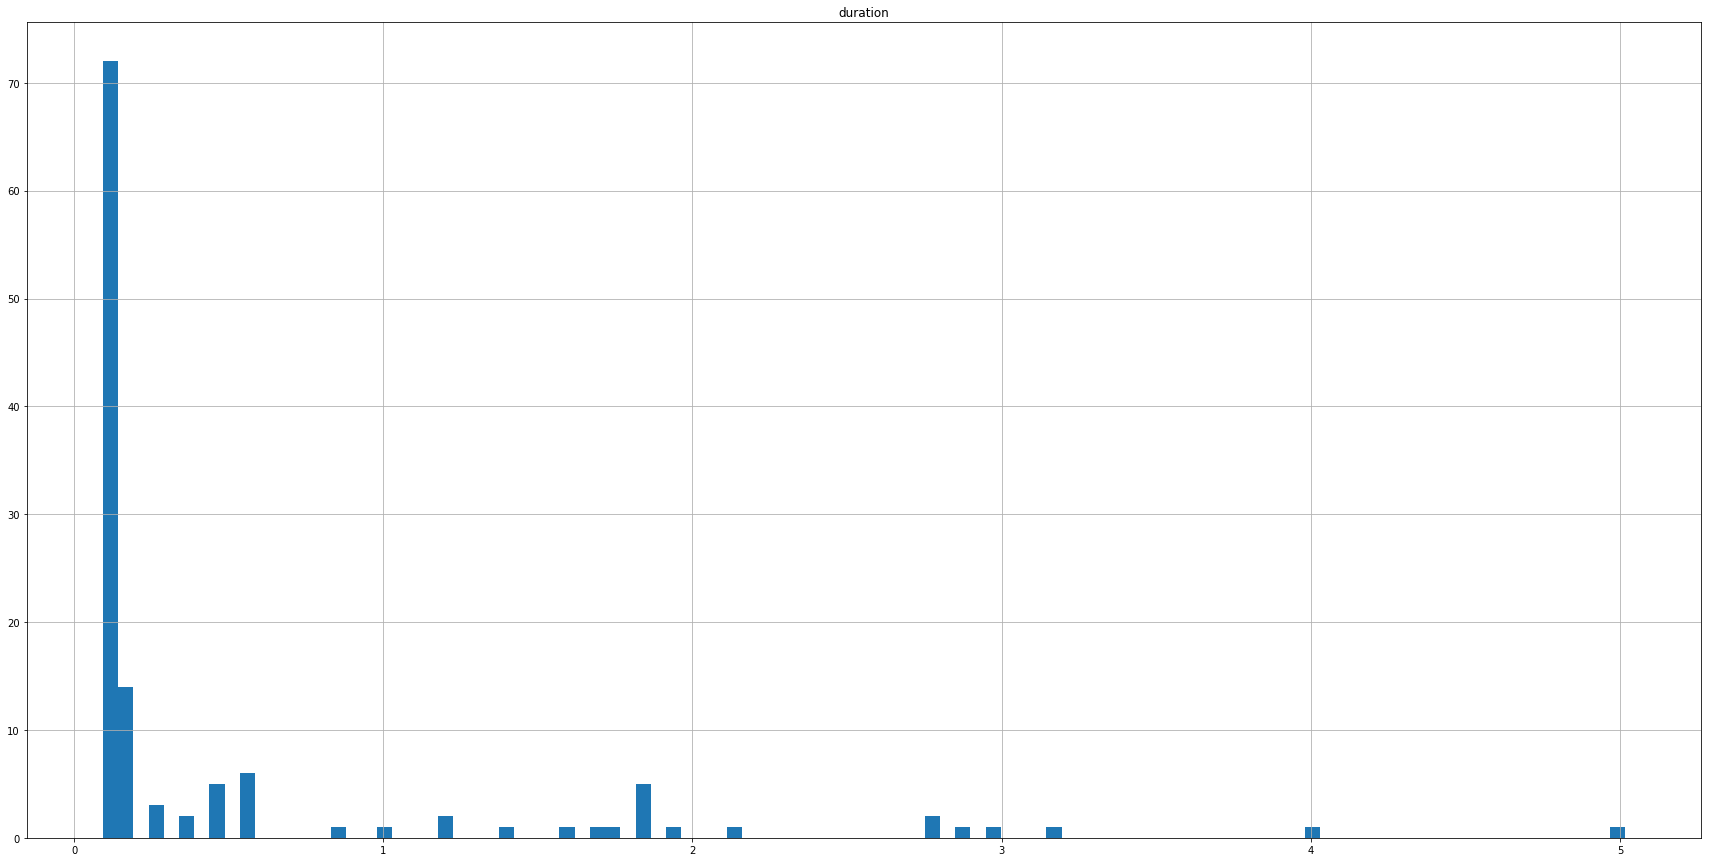

In [4]:
chunks.hist(column = 'duration', bins = 100, figsize = (30, 15))